# GradCAM Interpretability Study for ECG Classification

## Overview
This notebook presents a comprehensive interpretability analysis of a ResNet34-based ECG classifier using Gradient-weighted Class Activation Mapping (GradCAM) and related techniques.

### Model Details
- **Architecture**: ResNet34 with pre-trained ImageNet weights
- **Task**: Multi-class classification of ECG images
- **Classes**: 
  - MI (Myocardial Infarction)
  - PMI (Previous Myocardial Infarction)
  - HB (Abnormal Heartbeat)
  - Normal
- **Best Model**: `ecg-clf-best-epoch=12-acc=0.9677.ckpt` (96.77% accuracy)

### Study Objectives
1. Visualize which regions of ECG images the model focuses on for predictions
2. Compare different CAM methods (GradCAM, HiResCAM, ScoreCAM, etc.)
3. Analyze class-specific activation patterns
4. Identify potential model biases and areas for improvement
5. Validate clinical relevance of learned features

### Methods Analyzed
- **GradCAM**: Gradient-weighted Class Activation Mapping
- **GradCAM++**: Improved version with better localization
- **HiResCAM**: High-resolution class activation mapping
- **ScoreCAM**: Gradient-free CAM using model output scores
- **XGradCAM**: Axiom-based gradient CAM
- **EigenCAM**: Uses principal components of activations
- **FullGrad**: Full-Gradient representation
- **ShapleyCAM**: Game-theoretic approach based on Shapley values

In [1]:
# load model
from ecgclassifier_model import ECGClassifier
from random import randint
from matplotlib import pyplot as plt

model_path = "lightning_logs/ecg_clf/version_3/checkpoints/ecg-clf-best-epoch=12-acc=0.9677.ckpt"
model = ECGClassifier.load_from_checkpoint(model_path)

## 1. Model and Dataset Loading

In [5]:
from dataset import ECGDataset, DatasetWithTransform
import albumentations as A

val_test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet stats
    A.pytorch.ToTensorV2()
])

DATA_ROOT_DIR = '../../datasets/ecg/gwbz3fsgp8-2/'
ecg_dataset = DatasetWithTransform(ECGDataset(root_dir=DATA_ROOT_DIR, crop=(70, 285, 2175, 1517)),
                                   transform=val_test_transform)
ecg_dataset[0][0].shape

torch.Size([3, 224, 224])

## 2. Utility Functions

In [6]:
# invert the normalization for visualization
import numpy as np
from PIL import Image


def inverse_transform(image: np.ndarray) -> Image.Image:
    """Inverse the normalization transform."""
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inv_image = image * std + mean
    inv_image = np.clip(inv_image, 0, 1)
    return Image.fromarray((inv_image * 255).astype(np.uint8))

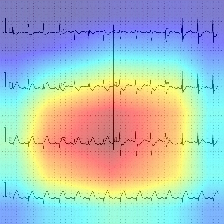

In [ ]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad, ShapleyCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import os

target_layers = [model.backbone.layer1[-1], model.backbone.layer4[-1]]
input_tensor = ecg_dataset[0][0]
input_tensor = input_tensor.unsqueeze(0)
rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0

targets = [ClassifierOutputTarget(0)]

with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    model_outputs = cam.outputs

# Criar diretório se não existir
os.makedirs('../texto/figuras/', exist_ok=True)

# Salvar exemplo básico
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(rgb_img)
axes[0].set_title('Imagem Original do ECG', fontsize=14, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(visualization)
axes[1].set_title('Mapa de Ativação Grad-CAM', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.savefig('../texto/figuras/exemplo_gradcam_basico.png', dpi=300, bbox_inches='tight')
plt.show()

Image.fromarray(visualization)

100%|██████████| 4/4 [00:00<00:00, 112.44it/s]



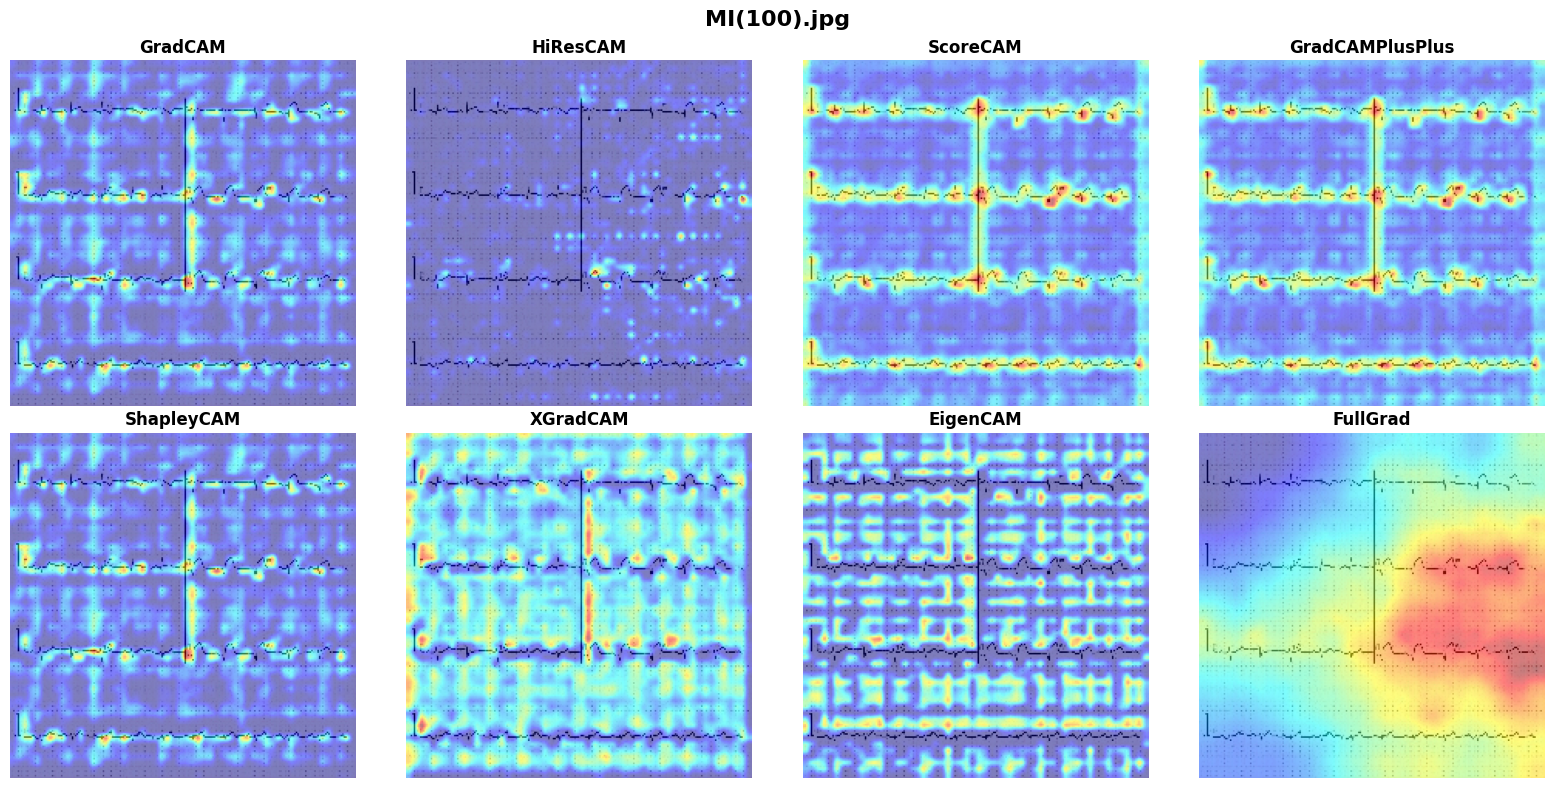

In [ ]:
from matplotlib import pyplot as plt
from math import ceil
import os

methods = [GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM, EigenCAM]

data_idx = randint(0, len(ecg_dataset)-1)
target_layers = [model.backbone.layer4[-1]]
input_tensor = ecg_dataset[data_idx][0]
input_tensor = input_tensor.unsqueeze(0)
rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0

targets = None

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

method_names_pt = {
    'GradCAM': 'Grad-CAM',
    'HiResCAM': 'HiRes-CAM',
    'ScoreCAM': 'Score-CAM',
    'GradCAMPlusPlus': 'Grad-CAM++',
    'XGradCAM': 'XGrad-CAM',
    'EigenCAM': 'Eigen-CAM'
}

for idx, method in enumerate(methods):
    with method(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        axes[idx].imshow(visualization)
        axes[idx].set_title(method_names_pt.get(method.__name__, method.__name__), 
                           fontsize=14, fontweight='bold')
        axes[idx].axis('off')

filename = os.path.basename(ecg_dataset.dataset.image_paths[data_idx])
true_class = ecg_dataset.dataset.classes[ecg_dataset[data_idx][1]]
fig.suptitle(f'Comparação de Métodos CAM\nClasse: {true_class}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/comparacao_metodos_cam.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sample_idx = np.random.choice(len(ecg_dataset))
input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
true_label = ecg_dataset[sample_idx][1]

rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0

layer_configs = [
    ('Camada 1', [model.backbone.layer1[-1]]),
    ('Camada 2', [model.backbone.layer2[-1]]),
    ('Camada 3', [model.backbone.layer3[-1]]),
    ('Camada 4', [model.backbone.layer4[-1]]),
]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, (layer_name, target_layer) in enumerate(layer_configs):
    with ScoreCAM(model=model, target_layers=target_layer) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    axes[idx].imshow(visualization)
    axes[idx].set_title(f'{layer_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

fig.suptitle(f'Análise por Camadas da Rede (Score-CAM)\nClasse Verdadeira: {ecg_dataset.dataset.classes[true_label]}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/analise_camadas.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
sample_idx = np.random.choice(len(ecg_dataset))
input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
true_label = ecg_dataset[sample_idx][1]

rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, class_name in enumerate(ecg_dataset.dataset.classes):
    with ScoreCAM(model=model, target_layers=[model.backbone.layer4[-1]]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(idx)])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    axes[idx].imshow(visualization)
    axes[idx].set_title(f'Classe: {class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

fig.suptitle(f'Análise por Classe (Camada 4)\nImagem Verdadeira: {ecg_dataset.dataset.classes[true_label]}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/analise_por_classe.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def analyze_activation_pattern(grayscale_cam):
    """Extract quantitative metrics from activation map."""
    return {
        'mean_activation': np.mean(grayscale_cam),
        'max_activation': np.max(grayscale_cam),
        'std_activation': np.std(grayscale_cam),
        'activation_above_50': np.sum(grayscale_cam > 0.5) / grayscale_cam.size,
        'activation_above_75': np.sum(grayscale_cam > 0.75) / grayscale_cam.size,
        'center_of_mass': np.array([
            np.average(np.arange(grayscale_cam.shape[0]), weights=grayscale_cam.sum(axis=1)),
            np.average(np.arange(grayscale_cam.shape[1]), weights=grayscale_cam.sum(axis=0))
        ])
    }

np.random.seed(42)
samples_per_class = 30
classes = ecg_dataset.dataset.classes
activation_stats = {class_name: [] for class_name in classes}

target_layers = [model.backbone.layer4[-1]]

for class_idx, class_name in enumerate(classes):
    class_samples = [i for i, label in enumerate(ecg_dataset.dataset.labels) if label == class_idx]
    selected_samples = np.random.choice(class_samples, min(samples_per_class, len(class_samples)), replace=False)
    
    for sample_idx in selected_samples:
        input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
        
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)
            grayscale_cam = grayscale_cam[0, :]
            
            stats = analyze_activation_pattern(grayscale_cam)
            activation_stats[class_name].append(stats)

metrics_to_plot = ['mean_activation', 'max_activation', 'std_activation', 
                   'activation_above_50', 'activation_above_75']

metric_names_pt = {
    'mean_activation': 'Ativação Média',
    'max_activation': 'Ativação Máxima',
    'std_activation': 'Desvio Padrão',
    'activation_above_50': 'Proporção > 0.5',
    'activation_above_75': 'Proporção > 0.75'
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    data_to_plot = [[stat[metric] for stat in activation_stats[class_name]] 
                    for class_name in classes]
    
    bp = axes[idx].boxplot(data_to_plot, labels=classes, patch_artist=True)
    
    colors = ['#ff9999', '#ffcc9999', '#99ccff', '#99ff99']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[idx].set_title(metric_names_pt[metric], fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Valor')
    axes[idx].set_xlabel('Classe')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

axes[5].set_title('Distribuição Espacial do Centro de Massa', fontsize=14, fontweight='bold')
for class_idx, class_name in enumerate(classes):
    centers = np.array([stat['center_of_mass'] for stat in activation_stats[class_name]])
    axes[5].scatter(centers[:, 1], centers[:, 0], label=class_name, alpha=0.6, s=50)
axes[5].set_xlabel('Posição Horizontal')
axes[5].set_ylabel('Posição Vertical')
axes[5].legend()
axes[5].grid(True, alpha=0.3)
axes[5].invert_yaxis()

fig.suptitle('Análise Quantitativa dos Padrões de Ativação por Classe', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/analise_quantitativa_ativacao.png', dpi=300, bbox_inches='tight')
plt.show()

## 10. Summary Statistics and Key Findings

In [ ]:
# Compare GradCAM across different ResNet layers
# Select a representative sample
sample_idx = np.random.choice(len(ecg_dataset))
input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
true_label = ecg_dataset[sample_idx][1]
# pred_label, confidence, all_probs = get_prediction_with_confidence(model, input_tensor)

rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0

# Different layers to analyze
layer_configs = [
    ('layer1', [model.backbone.layer1[-1]]),
    ('layer2', [model.backbone.layer2[-1]]),
    ('layer3', [model.backbone.layer3[-1]]),
    ('layer4', [model.backbone.layer4[-1]]),
    ('layer1+layer4', [model.backbone.layer1[-1], model.backbone.layer4[-1]]),
    ('all_layers', [model.backbone.layer1[-1], model.backbone.layer2[-1], model.backbone.layer3[-1], model.backbone.layer4[-1]])
]

nrows = ceil(len(layer_configs)/2)
fig, axes = plt.subplots(nrows, 2, figsize=(6*nrows, 12))
axes = axes.flatten()
for ax in axes:
    axes[idx].axis('off')

for idx, (layer_name, target_layer) in enumerate(layer_configs):
    with ScoreCAM(model=model, target_layers=target_layer) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    axes[idx].imshow(visualization)
    axes[idx].set_title(f'{layer_name}\n(receptive field increases →)', 
                       fontsize=12, fontweight='bold')

# fig.suptitle(f'Layer-wise GradCAM Analysis\nTrue: {classes[true_label]}, Pred: {classes[pred_label]} ({confidence:.2%})', 
#              fontsize=14, fontweight='bold')
fig.suptitle(f'Layer-wise Analysis\nTrue: {ecg_dataset.dataset.classes[true_label]}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/analise_camadas.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:

# Save the figure
fig.suptitle("Visualização dos mapas de ativação do Score-CAM extraídos de diferentes camadas", fontsize=16)
fig.savefig('../texto/figuras/analise_camadas.png', bbox_inches='tight')

🥇 ScoreCAM (Top Recommendation)
- Gradient-free: Doesn't rely on gradients that can be noisy or misleading
- Perturbation-based: Actually tests what happens when regions are masked/removed
- Directly measures impact: Shows which regions are truly necessary for the prediction
- Better for "absence" detection: Since it explicitly tests what happens when regions are missing
- Trade-off: More computationally expensive (requires multiple forward passes)

🥈 AblationCAM (Close Second)
- Explicit ablation: Systematically zeros out activations to measure importance
- Fast batched implementation: More efficient than ScoreCAM
- Direct causality: Shows what the model actually needs vs. what it just correlates with

## 9. Class-wise Analysis

Understanding how different classes contribute to the final decision.

In [ ]:
# Compare GradCAM across different ResNet layers
# Select a representative sample
sample_idx = np.random.choice(len(ecg_dataset))
input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
true_label = ecg_dataset[sample_idx][1]
# pred_label, confidence, all_probs = get_prediction_with_confidence(model, input_tensor)

rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, class_name in enumerate(ecg_dataset.dataset.classes):
    with ScoreCAM(model=model, target_layers=[model.backbone.layer4[-1]]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(idx)])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    axes[idx].imshow(visualization)
    axes[idx].set_title(f'Classe: {class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# fig.suptitle(f'Layer-wise GradCAM Analysis\nTrue: {classes[true_label]}, Pred: {classes[pred_label]} ({confidence:.2%})',
#              fontsize=14, fontweight='bold')
fig.suptitle(f'Layer-wise Analysis Layer 4\nTrue: {ecg_dataset.dataset.classes[true_label]}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/analise_por_classe.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Compare GradCAM across different ResNet layers
# Select a representative sample
sample_idx = np.random.choice(len(ecg_dataset))
input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
true_label = ecg_dataset[sample_idx][1]
# pred_label, confidence, all_probs = get_prediction_with_confidence(model, input_tensor)

rgb_img = inverse_transform(input_tensor[0].numpy().transpose(1, 2, 0))
rgb_img = np.array(rgb_img) / 255.0


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for idx, class_name in enumerate(ecg_dataset.dataset.classes):
    with ScoreCAM(model=model, target_layers=[model.backbone.layer1[-1], model.backbone.layer2[-1], model.backbone.layer3[-1], model.backbone.layer4[-1]]) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(idx)])
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    axes[idx].imshow(visualization)
    axes[idx].set_title(f'Classe: {class_name}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

# fig.suptitle(f'Layer-wise GradCAM Analysis\nTrue: {classes[true_label]}, Pred: {classes[pred_label]} ({confidence:.2%})',
#              fontsize=14, fontweight='bold')
fig.suptitle(f'Class-Wise analysis Layers 1 to 4\nTrue: {ecg_dataset.dataset.classes[true_label]}',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/analise_por_classe.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 32/32 [00:03<00:00, 10.20it/s]


🔬 Additional Insight:
The progression from Layer 1 → Layer 4 perfectly demonstrates the hierarchical feature learning of CNNs:

- Early layers: Basic patterns (lines)
- Deep layers: High-level diagnostic features (disease patterns)


## 6. Quantitative Analysis of Activation Patterns

Let's analyze the spatial distribution and intensity of activations across different classes.

In [ ]:
def analyze_activation_pattern(grayscale_cam):
    """Extract quantitative metrics from activation map."""
    return {
        'mean_activation': np.mean(grayscale_cam),
        'max_activation': np.max(grayscale_cam),
        'std_activation': np.std(grayscale_cam),
        'activation_above_50': np.sum(grayscale_cam > 0.5) / grayscale_cam.size,
        'activation_above_75': np.sum(grayscale_cam > 0.75) / grayscale_cam.size,
        'center_of_mass': np.array([
            np.average(np.arange(grayscale_cam.shape[0]), weights=grayscale_cam.sum(axis=1)),
            np.average(np.arange(grayscale_cam.shape[1]), weights=grayscale_cam.sum(axis=0))
        ])
    }

# Analyze patterns for each class
np.random.seed(42)
samples_per_class = 30
activation_stats = {class_name: [] for class_name in classes}

target_layers = [model.backbone.layer4[-1]]

for class_idx, class_name in enumerate(classes):
    class_samples = [i for i, label in enumerate(ecg_dataset.dataset.labels) if label == class_idx]
    selected_samples = np.random.choice(class_samples, min(samples_per_class, len(class_samples)), replace=False)
    
    for sample_idx in selected_samples:
        input_tensor = ecg_dataset[sample_idx][0].unsqueeze(0)
        
        with GradCAM(model=model, target_layers=target_layers) as cam:
            grayscale_cam = cam(input_tensor=input_tensor, targets=None)
            grayscale_cam = grayscale_cam[0, :]
            
            stats = analyze_activation_pattern(grayscale_cam)
            activation_stats[class_name].append(stats)

# Visualize statistics
metrics_to_plot = ['mean_activation', 'max_activation', 'std_activation', 
                   'activation_above_50', 'activation_above_75']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, metric in enumerate(metrics_to_plot):
    data_to_plot = [[stat[metric] for stat in activation_stats[class_name]] 
                    for class_name in classes]
    
    bp = axes[idx].boxplot(data_to_plot, labels=classes, patch_artist=True)
    
    # Color the boxes
    colors = ['#ff9999', '#ffcc9999', '#99ccff', '#99ff99']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[idx].set_title(metric_names_pt[metric], fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('Valor')
    axes[idx].set_xlabel('Classe')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].tick_params(axis='x', rotation=45)

# Spatial distribution of center of mass
axes[5].set_title('Distribuição Espacial do Centro de Massa', fontsize=14, fontweight='bold')
for class_idx, class_name in enumerate(classes):
    centers = np.array([stat['center_of_mass'] for stat in activation_stats[class_name]])
    axes[5].scatter(centers[:, 1], centers[:, 0], label=class_name, alpha=0.6, s=50)
axes[5].set_xlabel('Posição Horizontal')
axes[5].set_ylabel('Posição Vertical')
axes[5].legend()
axes[5].grid(True, alpha=0.3)
axes[5].invert_yaxis()  # Invert y-axis to match image coordinates

fig.suptitle('Análise Quantitativa dos Padrões de Ativação por Classe', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../texto/figuras/analise_quantitativa_ativacao.png', dpi=300, bbox_inches='tight')
plt.show()